In [73]:
import pandas as pd
from pathlib import Path
from datetime import timedelta
import altair as alt

In [79]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
data_path = Path("../Dataset/")

In [19]:
training_data = pd.read_csv(data_path/"Candidate_tech_evaluation_candidate_copy_data science_fraud.csv").drop(columns=['Unnamed: 0'])

In [20]:
training_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


# Data size

In [21]:
training_data.shape

(120000, 11)

The dataset is imblanced.  
About 9.7% of the record is fraud.  

In [13]:
training_data['class'].value_counts()

class
0    108735
1     11265
Name: count, dtype: int64

In [45]:
training_data['class'].value_counts()[0] / training_data['class'].value_counts()[1]

9.652463382157125

In [46]:
training_data[['purchase_value', 'age']].describe()

,purchase_value,age
count,120000.000000,120000.000000
mean,36.881475,33.125250
std,18.325855,8.617081
min,9.000000,18.000000
25%,22.000000,27.000000
50%,34.000000,33.000000
75%,49.000000,39.000000
max,154.000000,76.000000


# Data time range

The transactions happend during 2015 and signup did not happen after Aug 18th.

Each time feature itself seems to be normal

In [23]:
training_data['signup_time_dt'] = pd.to_datetime(training_data['signup_time'])
training_data['purchase_time_dt'] = pd.to_datetime(training_data['purchase_time'])

In [54]:
training_data['signup_time_dt'].value_counts()

signup_time_dt
2015-01-06 12:10:00    21
2015-01-06 12:53:00    20
2015-01-10 23:23:00    19
2015-01-03 10:47:00    17
2015-01-06 06:33:00    17
                       ..
2015-07-10 10:06:00     1
2015-04-14 11:38:00     1
2015-03-15 09:25:00     1
2015-06-16 04:52:00     1
2015-07-15 15:11:00     1
Name: count, Length: 109111, dtype: int64

In [24]:
training_data['signup_time_dt'].min(), training_data['signup_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-08-18 04:31:00'))

In [55]:
training_data['purchase_time_dt'].value_counts()

purchase_time_dt
2015-01-06 12:53:00    20
2015-01-06 12:10:00    19
2015-01-10 23:23:00    18
2015-01-03 10:47:00    16
2015-01-06 06:33:00    16
                       ..
2015-04-25 19:25:00     1
2015-05-02 18:24:00     1
2015-06-30 06:09:00     1
2015-11-13 05:48:00     1
2015-09-03 13:45:00     1
Name: count, Length: 100058, dtype: int64

In [26]:
training_data['purchase_time_dt'].min(), training_data['purchase_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-16 02:56:00'))

## Time Interval

In [36]:
training_data['days_signup_purchase'] = training_data['purchase_time_dt'] - training_data['signup_time_dt']

The time difference between signup and the first purchase is from 0 days to 119 days.  
0 days records are suspicious.  

In [50]:
training_data['days_signup_purchase'].value_counts()

days_signup_purchase
0 days 00:00:00      5936
0 days 00:01:00        85
101 days 03:57:00       7
16 days 14:41:00        6
38 days 11:41:00        6
                     ... 
25 days 10:07:00        1
92 days 12:32:00        1
44 days 10:20:00        1
88 days 22:41:00        1
39 days 15:20:00        1
Name: count, Length: 83730, dtype: int64

In [37]:
training_data['days_signup_purchase'].min(), training_data['days_signup_purchase'].max()

(Timedelta('0 days 00:00:00'), Timedelta('119 days 23:59:00'))

As suspected, all of the records that has 0 time interval between signup and purchase are fraud records.  
It is nearlly half of the records, the time interval is signigicant feature to predict fraud.  

In [52]:
op1 = training_data['days_signup_purchase'] == '0 days 00:00:00'
op2 = training_data['days_signup_purchase'] == '0 days 00:01:00'
training_data.loc[op1|op2, 'class'].value_counts()

class
1    6021
Name: count, dtype: int64

In [53]:
6021 / 11265

0.5344873501997337

Fraud transation spread overall

In [29]:
op1 = training_data['class'] == 1
training_data.loc[op1, 'signup_time_dt'].min(), training_data.loc[op1, 'signup_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-08-18 04:31:00'))

In [30]:
op1 = training_data['class'] == 1
training_data.loc[op1, 'purchase_time_dt'].min(), training_data.loc[op1, 'purchase_time_dt'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-13 12:00:00'))

In [57]:
training_data['signup_time_h_dt'] = training_data['signup_time_dt'].dt.hour
training_data['purchase_time_h_dt'] = training_data['purchase_time_dt'].dt.hour

## Time

There is no specific time that fraud happens

In [71]:
op1 = training_data['class'] == 1
training_data.loc[op1, ['signup_time_h_dt']].value_counts().sort_index()

signup_time_h_dt
0                   456
1                   410
2                   484
3                   482
4                   406
5                   424
6                   467
7                   424
8                   506
9                   558
10                  502
11                  441
12                  483
13                  482
14                  491
15                  481
16                  476
17                  545
18                  506
19                  536
20                  399
21                  415
22                  422
23                  469
Name: count, dtype: int64

In [70]:
op1 = training_data['class'] == 1
training_data.loc[op1, ['purchase_time_h_dt']].value_counts().sort_index()

purchase_time_h_dt
0                     441
1                     450
2                     467
3                     492
4                     398
5                     439
6                     482
7                     432
8                     523
9                     531
10                    487
11                    447
12                    493
13                    464
14                    477
15                    495
16                    486
17                    549
18                    482
19                    484
20                    409
21                    454
22                    413
23                    470
Name: count, dtype: int64

# Purchase values

The distribution of Purchase value right skewed.  
Some records that its value exceed around 1800 seems to be suspicious.  

<Axes: >

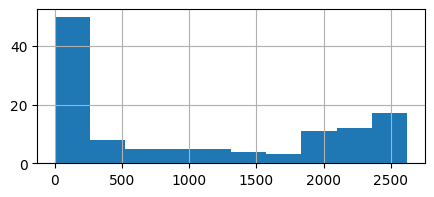

In [97]:
training_data[['purchase_value']].value_counts().hist(figsize=(5,2))

In [111]:
training_data['purchase_value'] = training_data['purchase_value'].astype(int)

In [117]:
op1 = training_data['purchase_value'] >= 1800
training_data.loc[op1, ['class']].value_counts()

(120000,)

# User id

In [14]:
training_data['user_id'].value_counts()

user_id
285108    1
375847    1
340683    1
302338    1
47270     1
         ..
170034    1
87898     1
180229    1
290767    1
341401    1
Name: count, Length: 120000, dtype: int64